In [1]:
# Temporary import. It will be removed in the final vserion
import os
import sys

import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
from pytagi.nn import LSTM, Linear, Sequential
from pytagi.LSTM_KF_RL_Env import LSTM_KF_Env

from examples.data_loader import TimeSeriesDataloader, SyntheticTimeSeriesDataloader
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm

from itertools import count
import random

In [2]:
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

# Network
net = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net.set_threads(8)
net.load(filename='./saved_param/HQ_hybrid_LSTM/lstm_hq_hybrid_onlydisp11.pth')
# #net.to_device("cuda")

# # State-space models: for baseline hidden states
phi_AA = 0.999
Sigma_AR = 0.11453**2
phi_AR = 0.51824134
Sigma_AA = Sigma_AR*1e-16
LA_var_stationary = Sigma_AA /(1-phi_AA**2)
AR_var_stationary = Sigma_AR /(1-phi_AR**2)
# Autoregressive acceleration + online AR
# hybrid = LSTM_SSM(
#     neural_network = net,           # LSTM
#     baseline = 'AA + AR', # 'level', 'trend', 'acceleration', 'ETS'
#     zB  = np.array([0.1, 1E-4, 0, 0.51824134, 0.02]),    # initial mu for baseline hidden states
#     SzB = np.array([1E-5, 1E-8, LA_var_stationary, 1E-16, Sigma_AR]),    # var
#     phi_AA = phi_AA,
#     Sigma_AR = Sigma_AR,
#     Sigma_AA = Sigma_AA,
# )
hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'AA + plain_AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = np.array([0.1, 1E-4, 0, 0.02]),    # initial mu for baseline hidden states
    SzB = np.array([1E-5, 1E-8, LA_var_stationary, AR_var_stationary]),    # var
    phi_AA = phi_AA,
    phi_AR = phi_AR,
    Sigma_AR = Sigma_AR,
    Sigma_AA = Sigma_AA,
    use_online_AR=False,
)
ts_mean = np.array([1.29422196, 26.12962963])
ts_std = np.array([1.04736457, 14.85491102])

random_column = random.randint(0, 19)

In [3]:
# Get initial state from a stationary synthetic time series
train_dtl = SyntheticTimeSeriesDataloader(
    x_file="data/HQ/syn_dataset_hqts2_lstm_unstandardized_model11_200episodes.csv",
    select_column = 4,
    # x_file="data/HQ/syn_dataset_hqts2_lstm_unstandardized_model4_ts1.csv",
    date_time_file="data/HQ/syn_dataset_hqts2_lstm_datetime.csv",
    x_mean=ts_mean,
    x_std=ts_std,
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
)
env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, \
                            ts_model=hybrid, step_look_back=8)
_, _ = env.reset()

for t in count():
    action = 0
    _, _, terminated, _, info = env.step(action)

    if terminated:
        break

In [4]:
train_dtl = TimeSeriesDataloader(
    x_file="data/HQ/hq_ts2.csv",
    date_time_file="data/HQ/hq_ts2_datetime.csv",
# train_dtl = SyntheticTimeSeriesDataloader(
#     x_file="data/HQ/syn_dataset_hqts2_lstm_unstandardized_model11_200episodes.csv",
#     select_column = 4,
#     # x_file="data/HQ/syn_dataset_hqts2_lstm_unstandardized_model4_ts1.csv",
#     date_time_file="data/HQ/syn_dataset_hqts2_lstm_datetime.csv",
#     add_anomaly = True,
#     anomaly_magnitude=-0.002,
#     anomaly_start=300,
    x_mean=ts_mean,
    x_std=ts_std,
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
)

[ 1.29422196 26.12962963] [ 1.04736457 14.85491102]


In [5]:
env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, \
                            ts_model=hybrid, step_look_back=8)
env.ts_model.z[2]=0
state, _ = env.reset(z=env.ts_model.z, Sz=env.ts_model.Sz)

for t in count():
    action = 0
    if t == 450:
        action = 1
    state, reward, terminated, _, info = env.step(action)
    print(reward)

    if terminated:
        break

1.0628292898533989
0.6508164768960736
1.0678218068142993
1.0037467392727475
1.0545776120825785
0.8850913453833389
1.023508388198394
0.6404448092780228
0.9264737076801746
0.6857047860473093
0.7341549132523157
-0.009464529370811547
1.0454831644500215
0.6423331345778793
-2.1870064062716548
0.18821929868845455
0.5507653314424044
1.0031560631446688
1.0337496812616793
0.8864092156469177
-0.6091162164436774
0.9658733912242212
0.7495929772117487
1.0211587442665708
0.976562217480101
1.0039482614521127
1.0017745847587651
0.5207551817000748
0.9411308050209009
0.9225817656853739
0.7556906027796373
0.004843339964478055
0.8521374680970579
1.0220568647855588
0.5971951220430141
-0.2816517205493305
0.626114905755438
0.34631173827584405
0.4766483115381641
0.8994526202551487
0.5686186790114416
-0.19632520753813676
1.043616443793498
0.9802410953596148
0.9647413400419511
0.960861205051855
0.2622626502855123
1.0517145360278972
0.9509534075950956
0.9019119649295062
0.49913506426013843
1.0271327328143176
0.07

In [6]:
mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()

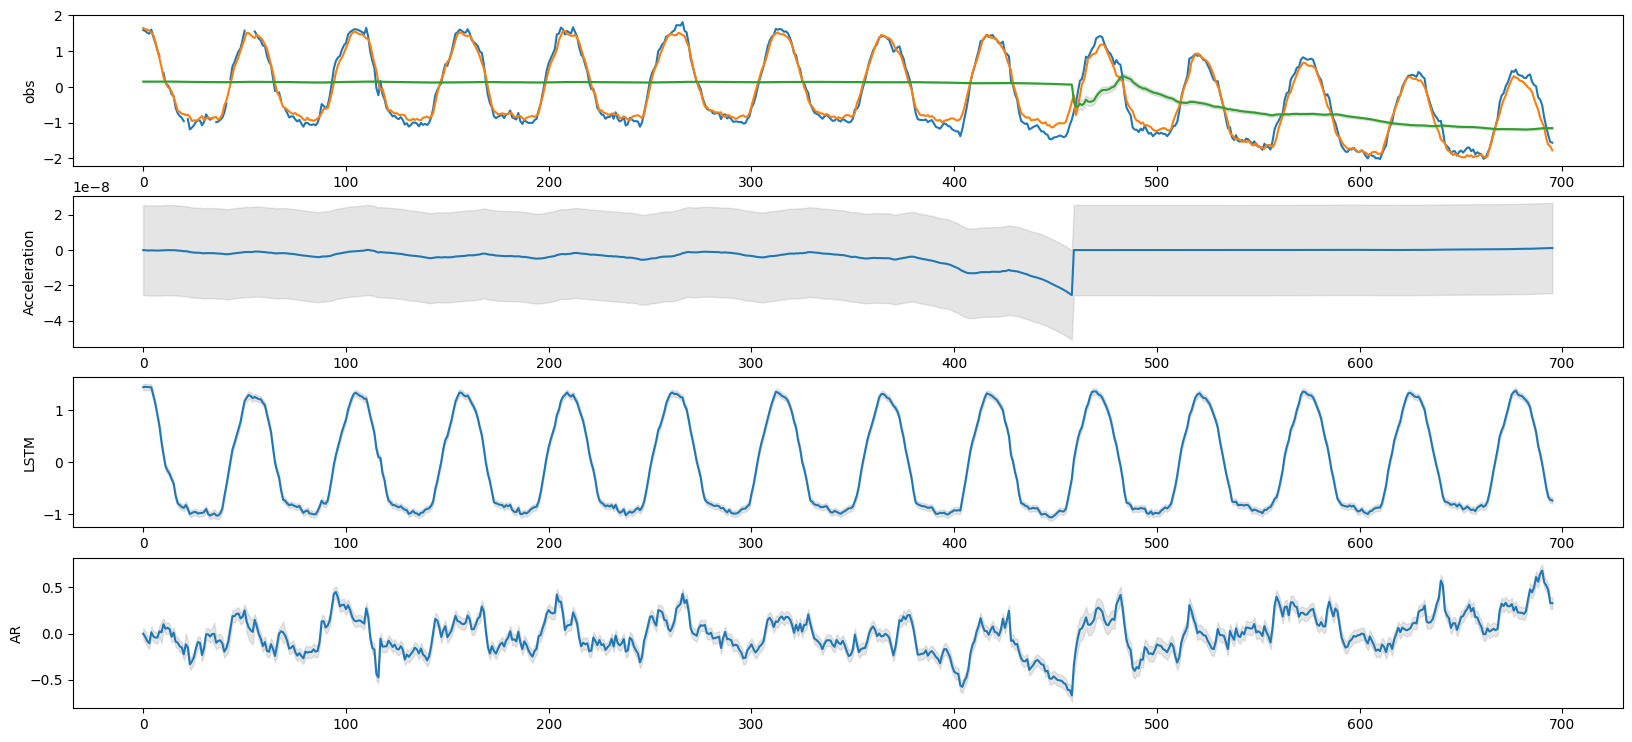

In [7]:
# Plot prediction
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

time_step_indices = np.arange(0, len(mu_hidden_states_one_episode[:,2]), 1)

# Plot prediction
ax0.plot(time_step_indices, info['measurement_one_episode'], label='Observation')
ax0.plot(time_step_indices, mu_prediction_one_episode, label='Prediction')
# ax0.fill_between(
#     time_step_indices,
#     mu_prediction_one_episode - np.sqrt(var_prediction_one_episode),
#     mu_prediction_one_episode + np.sqrt(var_prediction_one_episode),
#     alpha=0.2,
#     color='gray',
# )
ax0.plot(time_step_indices, mu_hidden_states_one_episode[:,0], label='LL hidden state')
ax0.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),
    mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]),
    alpha=0.2,
    color='gray',
)
ax0.set_ylabel('obs')
# ax0.set_title('Synthetic time series')

# Plot AA hidden states
ax1.plot(time_step_indices, mu_hidden_states_one_episode[:,2], label='AA hidden state')
ax1.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),
    mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]),
    alpha=0.2,
    color='gray',
)
# ax1.set_ylim(-3e-8,1e-8)
ax1.set_ylabel('Acceleration')

# Plot LSTM hidden states
ax2.plot(time_step_indices, mu_hidden_states_one_episode[:,-1], label='LSTM hidden state')
ax2.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),
    mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]),
    alpha=0.2,
    color='gray',
)
ax2.set_ylabel('LSTM')

# Plot AR hidden states
ax3.plot(time_step_indices, mu_hidden_states_one_episode[:,-2], label='AR hidden state')
ax3.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    alpha=0.2,
    color='gray',
)
ax3.set_ylabel('AR')
# ax3.set_ylim(-0.4,0.2)

plt.show()